Singular values: [1.00000000e+02 1.29154967e+01 1.66810054e+00 2.15443469e-01
 2.78255940e-02 3.59381366e-03 4.64158883e-04 5.99484250e-05
 7.74263683e-06 1.00000000e-06]

ANALYZING U^T V MATRICES AT 5 CHECKPOINTS

Checkpoint theta values: [0.001      0.06619007 0.13139317 0.19659628 0.26179939]

DETAILED ANALYSIS FOR COLUMNS [0, 4, 9]

Processing column 0...

Column 0 at θ = 0.001000
Norm = 9.999997e-05, Singular value = 1.000000e+02

Full U^T V matrix:
--------------------------------------------------
[  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000 ]
[  0.0000  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000 ]
[  0.0000  0.0000  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000 ]
[  0.0000  0.0000  0.0000  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000 ]
[  0.0000  0.0000  0.0000  0.0000  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000 ]
[  0.0000  0.0000  0.0000  0.0000  0.0000  1.0000  0.0000  0.0000  0.0

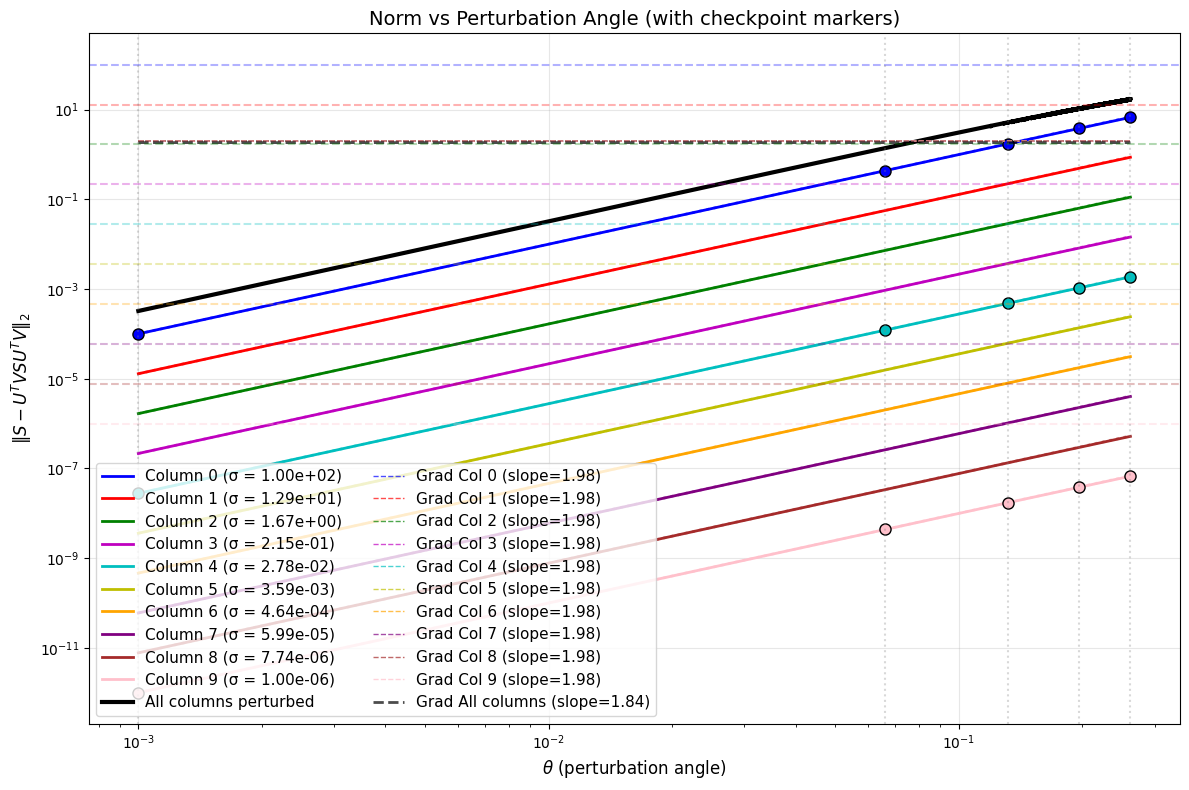


SUMMARY OF CHECKPOINT ANALYSIS

Column 0 (σ = 1.00e+02):
         θ         Norm     cos(θ)    U^TV[0,0]
--------------------------------------------------
  0.001000 9.999997e-05   1.000000     1.000000
  0.066190 4.374731e-01   0.997810     0.997810
  0.131393 1.716504e+00   0.991380     0.991380
  0.196596 3.815471e+00   0.980737     0.980737
  0.261799 6.698730e+00   0.965926     0.965926

Column 4 (σ = 2.78e-02):
         θ         Norm     cos(θ)    U^TV[4,4]
--------------------------------------------------
  0.001000 2.782558e-08   1.000000     1.000000
  0.066190 1.217295e-04   0.997810     0.997810
  0.131393 4.776275e-04   0.991380     0.991380
  0.196596 1.061678e-03   0.980737     0.980737
  0.261799 1.863961e-03   0.965926     0.965926

Column 9 (σ = 1.00e-06):
         θ         Norm     cos(θ)    U^TV[9,9]
--------------------------------------------------
  0.001000 1.000446e-12   1.000000     1.000000
  0.066190 4.374731e-09   0.997810     0.997810
  0.131393 1.7165

In [8]:
import numpy as np 
import scipy
import matplotlib.pyplot as plt

n, r = 20, 10
rng = np.random.default_rng(42)

# Create U and singular values using your approach
U_A, _ = scipy.linalg.qr(rng.standard_normal((n, r)), mode='economic')
sing_vals_A = np.logspace(-6, 2, r)[::-1]
S_A = np.diag(sing_vals_A)

# Create full n×n diagonal matrix S_full (padded with zeros)
S_full = np.zeros((n, n))
S_full[:r, :r] = S_A

# Extend U_A to full n×n orthogonal matrix
U_full, _ = scipy.linalg.qr(np.hstack([U_A, rng.standard_normal((n, n-r))]))

print(f"Singular values: {sing_vals_A}")

def perturb_column_and_compute_norm_with_UtV(U_A, S_A, col_idx, theta, rng, debug=False):
    """
    Perturb a specific column of U_A and compute ||(I - U^T V)S||_2
    Also returns U^T V matrix
    """
    # Prepare z (orthogonal to span(U_A), normed)
    z = rng.standard_normal((U_A.shape[0], 1))
    z -= U_A @ (U_A.T @ z)
    z /= np.linalg.norm(z)
    
    # Perturb the specified column
    V_A = U_A.copy()
    c, s = np.cos(theta), np.sin(theta)
    V_A[:, [col_idx]] = c * U_A[:, [col_idx]] + s * z
    V_A, _ = scipy.linalg.qr(V_A, mode="economic")
    
    # Compute (I - U^T V)S
    r = U_A.shape[1]
    UtV_rr = U_A.T @ V_A  # This is r×r
    I_r = np.eye(r)
    I_minus_UtV_rr = I_r - UtV_rr
    I_minus_UtV_S_rr = S_A - UtV_rr @ S_A @ UtV_rr
    norm_result = np.linalg.norm(I_minus_UtV_S_rr, ord='fro')
    
    # Debug information
    if debug:
        print(f"\nColumn {col_idx} perturbation:")
        print(f"U^T V diagonal elements: {np.diag(UtV_rr)}")
        print(f"(I - U^T V)[{col_idx},{col_idx}] = {I_minus_UtV_rr[col_idx,col_idx]:.6f}")
        print(f"||(I - U^T V)||_2 = {np.linalg.norm(I_minus_UtV_rr, ord='fro'):.6f}")
    
    return norm_result, UtV_rr

def perturb_column_and_compute_norm(U_A, S_A, col_idx, theta, rng, debug=False):
    """Original function for compatibility"""
    norm_result, _ = perturb_column_and_compute_norm_with_UtV(U_A, S_A, col_idx, theta, rng, debug)
    return norm_result

def perturb_all_columns_and_compute_norm(U_A, S_A, theta, rng, debug=False):
    """
    Perturb *all* columns of U_A by angle theta toward the same z, then compute ||(I - U^T V)S||_2
    """
    n, r = U_A.shape
    # Prepare z (orthogonal to span(U_A), normed)
    z = rng.standard_normal((n, 1))
    z -= U_A @ (U_A.T @ z)
    z /= np.linalg.norm(z)

    V_A = U_A.copy()
    c, s = np.cos(theta), np.sin(theta)
    # Perturb every column by the same angle theta
    for j in range(r):
        V_A[:, [j]] = c * U_A[:, [j]] + s * z
    V_A, _ = scipy.linalg.qr(V_A, mode="economic")

    r = U_A.shape[1]
    UtV_rr = U_A.T @ V_A
    I_r = np.eye(r)
    I_minus_UtV_rr = I_r - UtV_rr
    I_minus_UtV_S_rr = S_A - UtV_rr @ S_A @ UtV_rr
    norm_result = np.linalg.norm(I_minus_UtV_S_rr, ord='fro')

    # Debug information
    if debug:
        print(f"\nALL COLUMNS PERTURBED by θ={theta:.4f}")
        print(f"U^T V diagonal elements: {np.diag(UtV_rr)}")
        print(f"||(I - U^T V)||_2 = {np.linalg.norm(I_minus_UtV_rr, ord='fro'):.6f}")

    return norm_result

def print_utv_matrix(UtV, col_idx, theta, norm_val, sing_val):
    """Helper function to print U^T V matrix with formatting"""
    print(f"\n{'='*60}")
    print(f"Column {col_idx} at θ = {theta:.6f}")
    print(f"Norm = {norm_val:.6e}, Singular value = {sing_val:.6e}")
    print(f"{'='*60}")
    
    print("\nFull U^T V matrix:")
    print("-"*50)
    
    # Print the full matrix with formatting
    for row in range(r):
        row_str = "["
        for col in range(r):
            val = UtV[row, col]
            if abs(val) < 1e-10:
                row_str += f" {0:7.4f}"
            else:
                row_str += f" {val:7.4f}"
        row_str += " ]"
        print(row_str)
    
    print("\nDiagonal elements of U^T V:")
    print(f"{np.diag(UtV)}")
    
    # Check if it matches expected form
    expected_diag = np.ones(r)
    expected_diag[col_idx] = np.cos(theta)
    diag_diff = np.abs(np.diag(UtV) - expected_diag)
    print(f"\nExpected diagonal: {expected_diag}")
    print(f"Max diagonal deviation from expected: {np.max(diag_diff):.6e}")
    
    # Check off-diagonal elements
    off_diag_mask = np.ones((r, r), dtype=bool)
    np.fill_diagonal(off_diag_mask, False)
    max_off_diag = np.max(np.abs(UtV[off_diag_mask]))
    print(f"Max off-diagonal element magnitude: {max_off_diag:.6e}")

# Define which columns to analyze
columns_to_analyze = list(range(r))  # All columns

thetas = np.linspace(1e-3, np.pi / 12, 20000)

# Define checkpoints - 5 evenly spaced points in the theta range
checkpoint_indices = np.linspace(0, len(thetas)-1, 5, dtype=int)
checkpoint_thetas = thetas[checkpoint_indices]

print("\n" + "="*80)
print("ANALYZING U^T V MATRICES AT 5 CHECKPOINTS")
print("="*80)
print(f"\nCheckpoint theta values: {checkpoint_thetas}")

# Store results for each column
results = {}
colors = ['b', 'r', 'g', 'm', 'c', 'y', 'orange', 'purple', 'brown', 'pink']

# Analyze selected columns at checkpoints (showing first 3 columns for brevity)
columns_to_show_details = [0, 4, 9]  # First, middle, and last column

print("\n" + "="*80)
print(f"DETAILED ANALYSIS FOR COLUMNS {columns_to_show_details}")
print("="*80)

for i, col_idx in enumerate(columns_to_analyze):
    print(f"\nProcessing column {col_idx}...")
    norms = []
    actual_idx = col_idx if col_idx >= 0 else r + col_idx
    singular_value = sing_vals_A[actual_idx]
    
    for j, theta in enumerate(thetas):
        norm_val, UtV = perturb_column_and_compute_norm_with_UtV(U_A, S_A, col_idx, theta, rng, False)
        norms.append(norm_val)
        
        # Print detailed info at checkpoints for selected columns
        if col_idx in columns_to_show_details and j in checkpoint_indices:
            print_utv_matrix(UtV, col_idx, theta, norm_val, singular_value)
    
    results[col_idx] = norms

# Create the plot
plt.figure(figsize=(12, 8))

norms_all = []
for j, theta in enumerate(thetas):
    debug = (j == 0)
    norm_val = perturb_all_columns_and_compute_norm(U_A, S_A, theta, rng, debug)
    norms_all.append(norm_val)

for i, col_idx in enumerate(columns_to_analyze):
    color = colors[i % len(colors)]
    actual_idx = col_idx if col_idx >= 0 else r + col_idx
    label = f'Column {col_idx} (σ = {sing_vals_A[actual_idx]:.2e})'
    plt.loglog(thetas, results[col_idx], color=color, linestyle='-', 
               label=label, linewidth=2)
    plt.loglog(thetas, sing_vals_A[actual_idx] * thetas**2, color=color, 
               linestyle=':', alpha=0.5, linewidth=2)
    
    # Mark checkpoint locations for selected columns
    if col_idx in columns_to_show_details:
        checkpoint_norms = [results[col_idx][idx] for idx in checkpoint_indices]
        plt.plot(checkpoint_thetas, checkpoint_norms, 'o', color=color, 
                markersize=8, markeredgecolor='black', markeredgewidth=1)

plt.loglog(thetas, norms_all, color='k', label='All columns perturbed', linewidth=3)

# Calculate and plot gradients
print("\n" + "="*60)
print("GRADIENT ANALYSIS")
print("="*60)

# Calculate gradients in log-log space
log_thetas = np.log10(thetas)
gradients = {}

for i, col_idx in enumerate(columns_to_analyze):
    log_norms = np.log10(results[col_idx])
    # Calculate gradient using finite differences
    gradient = np.gradient(log_norms, log_thetas)
    gradients[col_idx] = gradient
    
    # Print average gradient for each column
    avg_gradient = np.mean(gradient)
    actual_idx = col_idx if col_idx >= 0 else r + col_idx
    print(f"Column {col_idx} (σ = {sing_vals_A[actual_idx]:.2e}): avg gradient = {avg_gradient:.3f}")
    
    # Only plot gradient if it's finite and reasonable
    if np.isfinite(avg_gradient) and abs(avg_gradient) < 100:
        color = colors[i % len(colors)]
        plt.loglog(thetas, np.full_like(thetas, abs(avg_gradient)), color=color, linestyle='--', 
                   alpha=0.7, linewidth=1, 
                   label=f'Grad Col {col_idx} (slope={avg_gradient:.2f})')

# Calculate gradient for all columns perturbed
log_norms_all = np.log10(norms_all)
gradient_all = np.gradient(log_norms_all, log_thetas)
avg_gradient_all = np.mean(gradient_all)
print(f"All columns perturbed: avg gradient = {avg_gradient_all:.3f}")

# Only plot if finite and reasonable
if np.isfinite(avg_gradient_all) and abs(avg_gradient_all) < 100:
    plt.loglog(thetas, np.full_like(thetas, abs(avg_gradient_all)), color='k', linestyle='--', 
               alpha=0.7, linewidth=2, label=f'Grad All columns (slope={avg_gradient_all:.2f})')

plt.xlabel(r'$\theta$ (perturbation angle)', fontsize=12)
plt.ylabel(r'$\|S - U^T VSU^TV\|_2$', fontsize=12)
plt.title('Norm vs Perturbation Angle (with checkpoint markers)', fontsize=14)
plt.legend(fontsize=11, ncol=2)
plt.grid(True, alpha=0.3)

# Add reference lines for all singular values being analyzed
for i, col_idx in enumerate(columns_to_analyze):
    actual_idx = col_idx if col_idx >= 0 else r + col_idx
    plt.axhline(y=sing_vals_A[actual_idx], color=colors[i % len(colors)], 
                linestyle='--', alpha=0.3)

# Add vertical lines at checkpoints
for theta_checkpoint in checkpoint_thetas:
    plt.axvline(x=theta_checkpoint, color='gray', linestyle=':', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("SUMMARY OF CHECKPOINT ANALYSIS")
print("="*80)

for col_idx in columns_to_show_details:
    actual_idx = col_idx if col_idx >= 0 else r + col_idx
    print(f"\nColumn {col_idx} (σ = {sing_vals_A[actual_idx]:.2e}):")
    print(f"{'θ':>10} {'Norm':>12} {'cos(θ)':>10} {'U^TV[{},{}]'.format(col_idx,col_idx):>12}")
    print("-"*50)
    
    for idx in checkpoint_indices:
        theta = thetas[idx]
        norm_val, UtV = perturb_column_and_compute_norm_with_UtV(U_A, S_A, col_idx, theta, rng, False)
        utv_diag = UtV[col_idx, col_idx]
        print(f"{theta:10.6f} {norm_val:12.6e} {np.cos(theta):10.6f} {utv_diag:12.6f}")